# Create HDF5 DataFrame for S values from alphawave FEKO files
see: http://www.h5py.org/

+ This notebook was based on `RFcalcUC_v8.py` module
+ It is used for the **TE-007** spatial averaging working group calculations

## Set up

In [1]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

import sys
import numpy as np
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.interpolate import interp1d, interp2d, griddata
from icecream import ic
import warnings
pd.options.display.max_rows = 800
from traceback import print_exc
from RFcalcUC_v9 import *

import seaborn as sn
sn.set()
%matplotlib inline

# Set current working directory to the notebook folder
%cd -0

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks


## Functions

In [2]:
def h5store(filename, df, **kwargs):
    '''Save a DF with its metadata to a HDF5 file
       see: http://stackoverflow.com/questions/29129095/save-additional-attributes-in-pandas-dataframe
       INPUTS:
         filename = filename of the hdf5 file, including .hdf5 extension
               df = dataframe to be saved as hdf5 store
           kwargs = dict of metadata to store with the dataframe'''
    
    store = pd.HDFStore(filename)
    store.put('mydata', df)
    store.get_storer('mydata').attrs.metadata = kwargs
    store.close()   

def getgrid(df):
    '''Create a dataframe of a grid's characteristics:
       min, max, n, delta'''
    
    def n(arr):
        '''Return number of unique elements in array'''
        return arr.unique().size

    def max_delta(arr):
        '''Return dx, dy or dz increment between x, y or z points'''
        return np.diff(np.sort(np.unique(arr))).max()
   
    grid = df[['x','y','z']].agg(['min','max',n,max_delta]).T
    grid['n'] = grid.n.astype(int)
    return grid

def dB(x):
    return 10. * np.log10(x)

def make_mgrid(df,c):
    '''Make an xyz mgrid for column c'''
    df = df.sort_values(['x','y','z'])
    nx = len(df.x.unique())
    ny = len(df.y.unique())
    nz = len(df.z.unique())
    C = df[c].values.reshape(nx, ny, nz)
    return C

def compliance_zone(df, dat, lim, antcolor='blue', title =''):
    '''Generate a mayavi 3D compliamce zone
       df = source dataframe, e.g. S, SARdf
      dat = data column, e.g. 'SE', 'SARwb'
      lim = limit value for compliance zone
    title = title text for the plot'''

    # Generate mgrids for xyz and data
    X = make_mgrid(df,'x')
    Y = make_mgrid(df,'y')
    Z = make_mgrid(df,'z')
    F = make_mgrid(df,dat)

    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(1200,900), bgcolor=(0.5, 0.5, 0.5))
    mlab.clf()

    # draw the iso-surfaces
    src = mlab.pipeline.scalar_field(X, Y, Z, F, name=dat)
    mlab.pipeline.iso_surface(src, contours=[lim,], opacity=0.5)
    mlab.axes(x_axis_visibility=True, y_axis_visibility=True,
              z_axis_visibility=True, line_width=1)
    
    # Draw the panel antenna
    panelAntenna(antcolor)
    
    # print plot title
    height, size = 0.85, 0.5
    mlab.title(title, height=height, size=size)

    mlab.show()
    
def showgridpoints(df, fields=['SARwb'], axv=(True,False,False),
                   bgcolor='lightgrey', fgcolor='black', antcolor='blue'):
    '''Show S and SAR grid points
    usage: .showgrids(S, SAR)
        df = dataframe
    fields = list of fields to display grid points for
       avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
   bgcolor = background color
   fgcolor = foreground color
  antcolor = color of the MBS panel antenna       
    '''
    from mayavi import mlab
    from collections.abc import Iterable
    
    # create the Mayavi figure
    fig = mlab.figure(1, size=(1200,900), 
                      bgcolor=COLORS[bgcolor],
                      fgcolor=COLORS[fgcolor])
    mlab.clf()

    # Make sure that fields is iterable
    if not isinstance(fields, Iterable): fields = [fields]

    # draw each of the field points
    possible_fields = df[3:].columns.to_list()
    for field in fields:
        assert field in possible_fields, f'field ({field}) must be one of {possible_fields}'

        # Get field grid point data
        dfd = df[['x','y','z',field]].dropna()

        # draw the field grid popints            
        pointcolor = COLORS['coral2'] if 'SAR' in field else COLORS['blue'] 
        mlab.points3d(dfd.x.values,dfd.y.values,dfd.z.values,
                      scale_factor=0.1,color=pointcolor,opacity=0.5)   # SAR grid

    # Get the extents
    g = df[['x','y','z']].agg(['min','max']).T
    extents = g.values.flatten().tolist()        

    # Add title
    title = 'grid points for: ' + ', '.join(fields)

    # draw the axes
    ax = mlab.axes(x_axis_visibility=axv[0], y_axis_visibility=axv[1],
                   z_axis_visibility=axv[2], line_width=1,
                   extent=extents,color=(0,0,0))
    ax.label_text_property.color = (0,0,0)
    ax.title_text_property.color = (0,0,0)
    ax.axes.label_format = '%g'
    ax.axes.font_factor = 1

    # Draw the panel antenna
    panelAntenna(antcolor)
    
    # Draw the scene
    mlab.title(title, height=0.85, size=0.15, color=COLORS[fgcolor])
    fig.scene.parallel_projection = True
    mlab.show()

## Look at model metadata for the spatial averaging trials

In [3]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

unit                                                  1  \
INPUT                                                                       
fMHz               MHz                                                900   
antenna                                           IEC 62232 panel antenna   
Prad                 W                                                 80   
dBiGain                                                                     
horizHPBW          deg                                                      
vertHPBW           deg                                                      
coordinate_origin                       centre of the middle feed segment   
xstart               m                                                0.5   
xend                 m                                                 14   
dx                   m                                                0.1   
ystart               m                                                 -7   
yend                 m                                                  7   
dy                   m                                                0.1   
zstart               m                                                 -3   
zend                 m                                                  3   
dz                   m                                                0.1   
bearing            deg                             main beam along x axis   
antenna_folder                                                 MBSpanel_1   
FEKO_Efile              IEC-62232-panel-antenna-standard-mesh_Grid3DFE...   
FEKO_Hfile              IEC-62232-panel-antenna-standard-mesh_Grid3DFE...   
SAR_file                                                                    
Notes                               IEC 62232 generic panel antenna model   

                                                                   2  \
INPUT                                                                  
fMHz                                                             900   
antenna                                      IEC 62232 panel antenna   
Prad                                                             200   
dBiGain                                                                
horizHPBW                                                              
vertHPBW                                                               
coordinate_origin                  centre of the middle feed segment   
xstart                                                            -1   
xend                                                              14   
dx                                                               0.1   
ystart                                                            -7   
yend                                                               7   
dy                                                               0.1   
zstart                                                            -3   
zend                                                               3   
dz                                                               0.1   
bearing                                       main beam along x axis   
antenna_folder                                            MBSpanel_2   
FEKO_Efile         IEC-62232-panel-antenna-NearField_NearField.ef...   
FEKO_Hfile         IEC-62232-panel-antenna-NearField_NearField.hf...   
SAR_file                      IEC_Panel_antenna_wbSAR-2022-12-15.csv   
Notes              Updated phantom with proper size and dielectri...   

                                                                   3  \
INPUT                                                                  
fMHz                                                             900   
antenna                                                         Yagi   
Prad                                                             100   
dBiGain                                                                
horizHPB

## Read in the E and H data from the FEKO zip files

In [4]:
# Set the trial number
trial = 2

# Get E and H FEKO data file locations
t = trials[str(trial)]
datadir = f'../antennas/{t.antenna_folder}/data/'
Efile = t.FEKO_Efile
Hfile = t.FEKO_Hfile

In [5]:
# Read in E-field FEKO data
print(f'{Efile = }')
Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
Edat = Edat.sort_values(['x','y','z'])
display(Edat.head())

# Read in H-field FEKO data
print(f'{Hfile = }')
Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
Hdat = Hdat.sort_values(['x','y','z'])
display(Hdat.head())

# Calculate SE, SH, Smax
SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
Smax = np.max([SE,SH],axis=0)

S = pd.DataFrame(dict(x=Edat.x,y=Edat.y,z=Edat.z,SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
S.head()

Efile = 'IEC-62232-panel-antenna-NearField_NearField.efe.zip'


x    y    z       Exr       Exi       Eyr       Eyi       Ezr  \
0     -1.0 -7.0 -3.0 -0.028640 -0.058473  0.713236 -0.061116 -2.205602   
21291 -1.0 -7.0 -2.9  0.024571 -0.072915  0.605318  0.361397 -1.964427   
42582 -1.0 -7.0 -2.8  0.073859 -0.041455  0.276137  0.597169 -1.110294   
63873 -1.0 -7.0 -2.7  0.085810  0.016590 -0.075913  0.572119 -0.032684   
85164 -1.0 -7.0 -2.6  0.054429  0.064586 -0.281270  0.374356  0.871428   

            Ezi  
0      0.032206  
21291 -1.180912  
42582 -2.022935  
63873 -2.253538  
85164 -1.960247

Hfile = 'IEC-62232-panel-antenna-NearField_NearField.hfe.zip'


x    y    z       Hxr       Hxi       Hyr       Hyi       Hzr  \
0     -1.0 -7.0 -3.0  0.006131 -0.000123 -0.000757  0.000119 -0.000313   
21291 -1.0 -7.0 -2.9  0.005423  0.003283 -0.000772 -0.000303 -0.000168   
42582 -1.0 -7.0 -2.8  0.002990  0.005586 -0.000548 -0.000679  0.000052   
63873 -1.0 -7.0 -2.7 -0.000014  0.006129 -0.000167 -0.000876  0.000209   
85164 -1.0 -7.0 -2.6 -0.002448  0.005215  0.000233 -0.000856  0.000225   

            Hzi  
0     -0.000098  
21291 -0.000282  
42582 -0.000306  
63873 -0.000180  
85164 -0.000006

x    y    z        SE        SH      Smax
0 -1.0 -7.0 -3.0  0.007138  0.007219  0.007219
1 -1.0 -7.0 -2.9  0.007635  0.007725  0.007725
2 -1.0 -7.0 -2.8  0.007646  0.007729  0.007729
3 -1.0 -7.0 -2.7  0.007189  0.007244  0.007244
4 -1.0 -7.0 -2.6  0.006404  0.006415  0.006415

In [6]:
display(getgrid(S))
ic(len(S))

min   max    n  max_delta
x -1.0  14.0  151        0.1
y -7.0   7.0  141        0.1
z -3.0   3.0   61        0.1

ic| len(S): 1298751


1298751

## Get antenna pattern data 

In [7]:
horiz_pattern_file = 'IEC-62232-panel-antenna_horCutFF.ffe'
vert_pattern_file = 'IEC-62232-panel-antenna_verCutFF.ffe'
Enames2 = ["theta","phi","Re_Etheta","Im_Etheta","Re_Ephi","Im_Ephi","directivity_theta","directivity_phi","directivity_total"]
hpat = pd.read_csv(datadir + horiz_pattern_file, sep='\s+', skiprows=17, names=Enames2)
vpat = pd.read_csv(datadir + vert_pattern_file, sep='\s+', skiprows=17, names=Enames2)
hpat.name = 'horizontal pattern'
vpat.name = 'vertical pattern'
cols = ['theta','phi','directivity_total']
print(hpat.name)
display(hpat.agg([min,max])[cols])
print(vpat.name)
display(vpat.agg([min,max])[cols])

horizontal pattern


theta   phi  directivity_total
min   90.0 -89.0           5.115236
max   90.0  90.0          17.031841

vertical pattern


theta  phi  directivity_total
min    1.0  0.0        -106.570073
max  180.0  0.0          17.031841

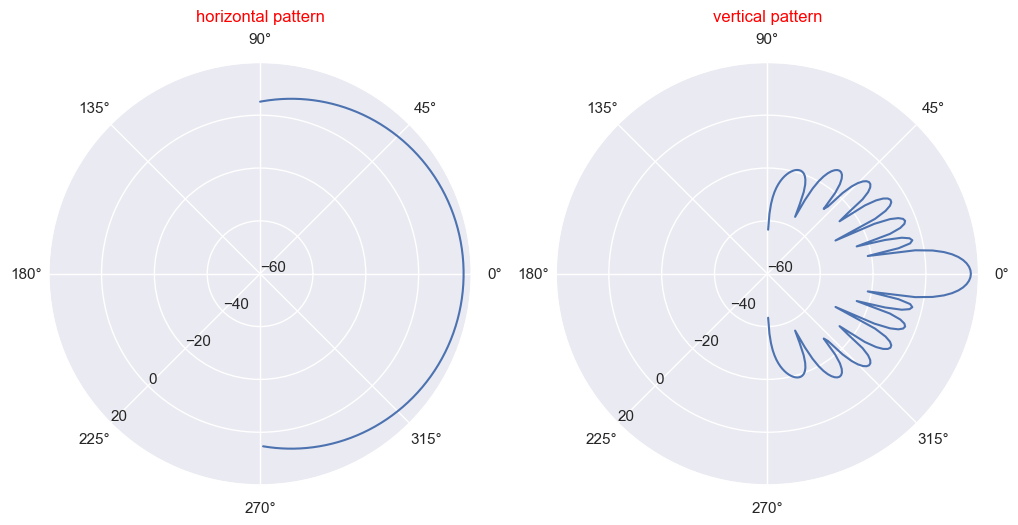

In [8]:
# Plot the horizontal and vertical antenna patterns
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6),
                       subplot_kw={'projection': 'polar'})
rticks = np.arange(-60,40,20)

for i, (df,angle) in enumerate(zip([hpat,vpat],['phi','theta'])):
    theta = df[angle] * np.pi / 180
    if 'vert' in df.name:
        theta = theta - np.pi/2 
    r = df.directivity_total
    ax[i].plot(theta, r)
    ax[i].set_rmax(rticks.max())
    ax[i].set_rmin(rticks.min())
    ax[i].set_rticks(rticks)
    ax[i].set_rlabel_position(225)  # Move radial labels away from plotted line
    ax[i].grid(True)
    ax[i].set_title(df.name, c='red', va='bottom');

In [9]:
# Antenna gain check at x = 14m
xp = 14         # distance to point from origin
d = xp + 0.04   # distance to point from antenna phase centre
g = 17.031841   # antenna gain (dBi) 
G = 10**(g/10)  # antenna gain (linear)
P = 200          # radiated antenna power
D = 2.25        # vertical length of the antenna reflector

# Calculate S from Friis equation
SFriis = P * G /(4 * np.pi * d**2)
SFriis = round(SFriis, 2)

# Get Smax from Danie's FEKO anaylsis
mask = (S.x == xp) & (S.y == 0) & (S.z == 0)
Spoint = S.loc[mask,'Smax'].round(2).values[0]

# Calculate far field distance

dff = 2 * D**2 / (300/900)

print(f'{SFriis = } W/m², {Spoint = } W/m²')
print(f'2d²/\u03BB = {dff:0.1f}m')

SFriis = 4.08 W/m², Spoint = 3.84 W/m²
2d²/λ = 30.4m


Since the assessment point (14.04m) is well inside $2d^2/\lambda$ (30.4m), then $S_{Friis}$ and $S_{point}$ are close but do not match exactly.

## Get SAR data
This version only **interpolates** the SAR values

### Read in Danie's SAR data file
Danie's SAR calcs were conducted for an **80W** antenna. The E/E field levels were calculated for **200W** radiated power. In order to make the SAR figures compatible with the E/H data we need to multiply the SAR data by 200/80

In [10]:
# Read in csv data file
SARdf = pd.read_csv(datadir + t.SAR_file, usecols=[0,1,2,4]).astype(float)
SARdf.head()

# Scale the SARwb values
SARdf['SARwb'] = SARdf.SARwb * 200/80

### Show grid points for the SARwb data

In [11]:
# Print unique x, y, z coordinate values
print('x values:', *SARdf.x.unique())
print('y values:', *SARdf.y.unique())
print('z values:', *SARdf.z.unique(), '\n')

x values: -0.8 -0.3 0.2 0.5 0.8 1.3 2.0 3.2 5.0 7.3 10.0 13.0
y values: 0.0 0.3 0.8 1.6 2.6 4.0 6.0
z values: -2.0 -1.0 0.0 1.0 2.0 



In [12]:
import RFcalcUC_v9
reload(RFcalcUC_v9)
from RFcalcUC_v9 import *
show_grid_points(SARdf,fields=['SARwb'], axv=(True,True,False),hman=1.6,
                 antcolor='gold')

### Get characterstics of the S and SARdf grids

In [13]:
SARgrid = getgrid(SARdf)
Sgrid = getgrid(S)
display('SAR grid',SARgrid)
display('S grid',Sgrid)

ic(SARdf.x.unique(),SARdf.y.unique(),SARdf.z.unique());

'SAR grid'

min   max   n  max_delta
x -0.8  13.0  12        3.0
y  0.0   6.0   7        2.0
z -2.0   2.0   5        1.0

'S grid'

min   max    n  max_delta
x -1.0  14.0  151        0.1
y -7.0   7.0  141        0.1
z -3.0   3.0   61        0.1

ic| SARdf.x.unique(): array([-0.8, -0.3,  0.2,  0.5,  0.8,  1.3,  2. ,  3.2,  5. ,  7.3, 10. ,
                             13. ])
    SARdf.y.unique(): array([0. , 0.3, 0.8, 1.6, 2.6, 4. , 6. ])
    SARdf.z.unique(): array([-2., -1.,  0.,  1.,  2.])


### Fill out the y<0 symmetry plane data

In [14]:
SARdfm = SARdf.copy()    # mirror copy
SARdfm['y'] = -SARdfm.y  # mirror the y values
SARdfall = pd.concat([SARdf, SARdfm])
SARdfall = SARdfall.drop_duplicates().sort_values(['x','y','z']).reset_index(drop=True)
SARdfall = SARdfall.astype({'y': 'float64','z':'float64'})

# check y symmetry for fixed x & z coordinates
mask = (SARdfall.x == -0.8) & (SARdfall.z == 2) 
SARdfall[mask]

x    y    z     SARwb
4  -0.8 -6.0  2.0  0.000194
9  -0.8 -4.0  2.0  0.000191
14 -0.8 -2.6  2.0  0.000255
19 -0.8 -1.6  2.0  0.000298
24 -0.8 -0.8  2.0  0.000244
29 -0.8 -0.3  2.0  0.000110
34 -0.8  0.0  2.0  0.000067
39 -0.8  0.3  2.0  0.000110
44 -0.8  0.8  2.0  0.000244
49 -0.8  1.6  2.0  0.000298
54 -0.8  2.6  2.0  0.000255
59 -0.8  4.0  2.0  0.000191
64 -0.8  6.0  2.0  0.000194

### Interpolation functions

In [15]:
def axisvals(axis, delta, df):
    '''Generate points for axis in df for delta increment'''
    minval = df[axis].min()
    maxval = df[axis].max()
    return np.arange(minval, maxval+delta, delta).round(8)

def SARinterpolator1d(df, ax1, newaxisvals, kind):
    '''Interpolate SARwb values in df along specified x, y or z axis
    INPUTS:
      df = input dataframe
      ax1 = axis to intepolate along ['x', 'y' or 'z']
      newaxisvals = interpolation points along the ax1 axis
      kind = type of interpolation [linear, quadractic, cubic, etc]
    OUTPUTS:
      df1 = dataframe with interpolated SARwb values
      '''
    print(f'{kind} log interpolation along the {ax1} axis ...')
    
    # Get axis names for ax2, ax3
    other_axes = dict(x=('y','z'),y=('x','z'),z=('x','y'))
    ax2, ax3 = other_axes[ax1]
    
    # Create empty dataframe
    df1 = pd.DataFrame(columns=('x','y','z','SARwb')) # initialise empty dataframe
    
    # Groupby over ax2 and ax3 axes
    for (ax2val,ax3val), g in df.groupby([ax2, ax3]):
        
        # Create 1d interpolation function
        xx = g[ax1].values.astype(float)      # have to coerce type to float for numpy ufuncs
        SARwb = g.SARwb.values.astype(float)  # have to coerce type to float for numpy ufuncs
        yy = np.log10(SARwb)
        f = interp1d(xx, yy, kind=kind)
        ff = lambda newaxisvals: 10**f(newaxisvals)
    
        # do interpolation over ax1 axis
        SARwb = ff(newaxisvals)
        dfi = pd.DataFrame({ax1:newaxisvals, ax2:ax2val, ax3:ax3val, 'SARwb':SARwb})
        df1 = pd.concat([df1, dfi])
        
    df1 = df1.sort_values(['x','y','z']).reset_index(drop=True)
    return df1.astype(float)

### Interpolate SARdfall over x, y & z axes

In [16]:
# Set interpolation parameters
delta = 0.1                            # increment axis points
xnew = axisvals('x', delta, SARdfall)  # new x-value interpolation points
ynew = axisvals('y', delta, SARdfall)  # new y-value interpolation points
znew = axisvals('z', delta, SARdfall)  # new z-value interpolation points

# Conduct x, y and z axis interpolations
SARdfi_x = SARinterpolator1d(SARdfall,'x',xnew,'quadratic')
SARdfi_xy = SARinterpolator1d(SARdfi_x,'y',ynew,'quadratic')
SARdfi_xyz = SARinterpolator1d(SARdfi_xy,'z',znew,'quadratic')

# Rename SARwb to SARwbi
SARdfi_xyz.rename(columns={'SARwb':'SARwbi'},inplace=True)
display(SARdfi_xyz)

# Show SAR grid parameters
getgrid(SARdfi_xyz)

quadratic log interpolation along the x axis ...
quadratic log interpolation along the y axis ...
quadratic log interpolation along the z axis ...


x    y    z    SARwbi
0       -0.8 -6.0 -2.0  0.000176
1       -0.8 -6.0 -1.9  0.000228
2       -0.8 -6.0 -1.8  0.000292
3       -0.8 -6.0 -1.7  0.000371
4       -0.8 -6.0 -1.6  0.000467
...      ...  ...  ...       ...
689574  13.0  6.0  1.6  0.005926
689575  13.0  6.0  1.7  0.005033
689576  13.0  6.0  1.8  0.004231
689577  13.0  6.0  1.9  0.003521
689578  13.0  6.0  2.0  0.002900

[689579 rows x 4 columns]

min   max    n  max_delta
x -0.8  13.0  139        0.1
y -6.0   6.0  121        0.1
z -2.0   2.0   41        0.1

### Display SARdfi_xyz isocontour

In [17]:
compliance_zone(df=SARdfi_xyz,dat='SARwbi',lim=0.04, antcolor='yellow',
                 title=f'interpolated SARdfi_xyz values on {delta}m mesh')

### Check symmetry of SARdfi_xyz in the z direction

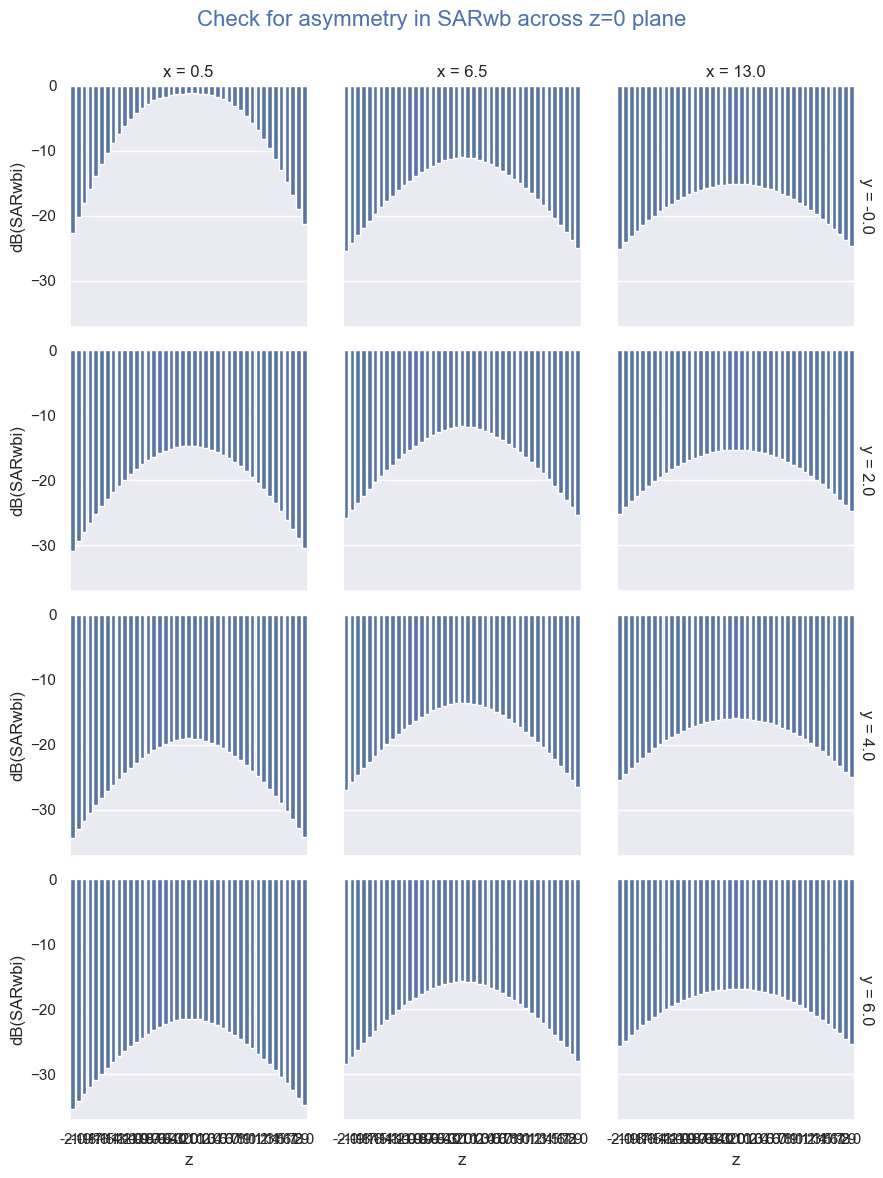

In [18]:
# Bar plots of dB(SARwb) along z for various values of x and y
SARdfi = SARdfi_xyz.copy()
SARdfi['dB(SARwbi)'] = dB(SARdfi.SARwbi)
xvals = [0.5,6.5,13]
yvals = [0,2,4,6]

mask = (SARdfi.x.isin(xvals)) & (SARdfi.y.isin(yvals))
g = sn.FacetGrid(SARdfi[mask], col="x", row="y",margin_titles=True)
g.map(sn.barplot, 'z', "dB(SARwbi)", order=np.sort(SARdfi_xyz.z.unique()))
plt.suptitle(f"Check for asymmetry in SARwb across z=0 plane\n",fontsize=16,c='b')
plt.tight_layout();

Data looks nicely symmetric in the z axis. It is *not* expected to be perfectly symmetric since the body phantom is not totally symmetric in the z direction

### Merge SARdf and SARdfi_xyz with S

In [19]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdfall,how='outer',on=['x','y','z'])
Sall = Sall.merge(SARdfi_xyz,how='outer',on=['x','y','z']).sort_values(['x','y','z'],ignore_index=True)
Sall

x    y    z        SE        SH      Smax  SARwb  SARwbi
0        -1.0 -7.0 -3.0  0.007138  0.007219  0.007219    NaN     NaN
1        -1.0 -7.0 -2.9  0.007635  0.007725  0.007725    NaN     NaN
2        -1.0 -7.0 -2.8  0.007646  0.007729  0.007729    NaN     NaN
3        -1.0 -7.0 -2.7  0.007189  0.007244  0.007244    NaN     NaN
4        -1.0 -7.0 -2.6  0.006404  0.006415  0.006415    NaN     NaN
...       ...  ...  ...       ...       ...       ...    ...     ...
1298746  14.0  7.0  2.6  0.063321  0.062714  0.063321    NaN     NaN
1298747  14.0  7.0  2.7  0.054166  0.053716  0.054166    NaN     NaN
1298748  14.0  7.0  2.8  0.048698  0.048395  0.048698    NaN     NaN
1298749  14.0  7.0  2.9  0.045836  0.045667  0.045836    NaN     NaN
1298750  14.0  7.0  3.0  0.044632  0.044577  0.044632    NaN     NaN

[1298751 rows x 8 columns]

In [20]:
Sall

x    y    z        SE        SH      Smax  SARwb  SARwbi
0        -1.0 -7.0 -3.0  0.007138  0.007219  0.007219    NaN     NaN
1        -1.0 -7.0 -2.9  0.007635  0.007725  0.007725    NaN     NaN
2        -1.0 -7.0 -2.8  0.007646  0.007729  0.007729    NaN     NaN
3        -1.0 -7.0 -2.7  0.007189  0.007244  0.007244    NaN     NaN
4        -1.0 -7.0 -2.6  0.006404  0.006415  0.006415    NaN     NaN
...       ...  ...  ...       ...       ...       ...    ...     ...
1298746  14.0  7.0  2.6  0.063321  0.062714  0.063321    NaN     NaN
1298747  14.0  7.0  2.7  0.054166  0.053716  0.054166    NaN     NaN
1298748  14.0  7.0  2.8  0.048698  0.048395  0.048698    NaN     NaN
1298749  14.0  7.0  2.9  0.045836  0.045667  0.045836    NaN     NaN
1298750  14.0  7.0  3.0  0.044632  0.044577  0.044632    NaN     NaN

[1298751 rows x 8 columns]

In [24]:
# show_grid_points(Sall,fields=['Smax','SARwb'], 
#                  antcolor='yellow', axv=(True,True,False))

### Add nan points in Sall to in any gaps in the cube space

In [37]:
# # Get the points for each axis
# xpoints = np.sort(Sall.x.unique())
# ypoints = np.sort(Sall.y.unique())
# zpoints = np.sort(Sall.z.unique())

# # Create a nan df of nan's for the entire cubic space of the axis points
# xvals,yvals,zvals = np.meshgrid(xpoints,ypoints,zpoints)
# xvals = xvals.flatten()
# yvals = yvals.flatten()
# zvals = zvals.flatten()

# dfnan = pd.DataFrame(dict(x=xvals,y=yvals,z=zvals))
# for col in Sall.columns[3:]:
#     dfnan[col] = np.nan
    
# # Concat the nan df to Sall and then get rid of any duplicates introduced by the nan df    
# Sall_filled = pd.concat([Sall,dfnan])
# Sall_filled = Sall_filled.drop_duplicates(['x','y','z'],keep='first').sort_values(['x','y','z'])
# Sall_filled

# g = getgrid(Sall_filled)
# display(g)
# g.n.prod()

In [22]:
# showgridpoints(Sall_filled,fields=['Smax'], axv=(True,True,False))

### Compare histogram of Danie's SARwb values with my log-quadratic interpolated values (SARwbi)

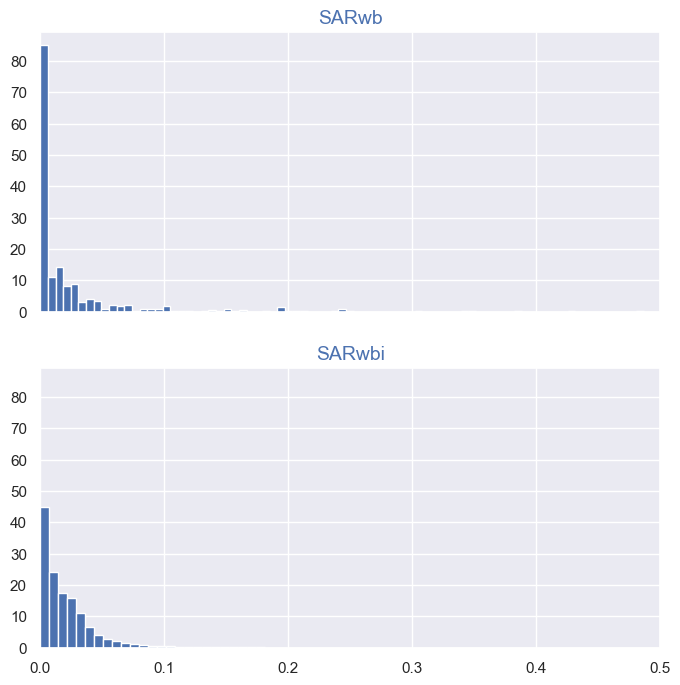

In [21]:
df = Sall
fig, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(8, 8))
bins = 200
df.SARwb.hist(bins=bins,ax=ax[0],density=True)
df.SARwbi.hist(bins=bins,ax=ax[1],density=True)
ax[0].set_title('SARwb',fontsize=14,color='b')
ax[1].set_title('SARwbi',fontsize=14,color='b');
plt.xlim(0,0.5);

Danie's SAR data and my interpolated data have similar histogram distributions

''

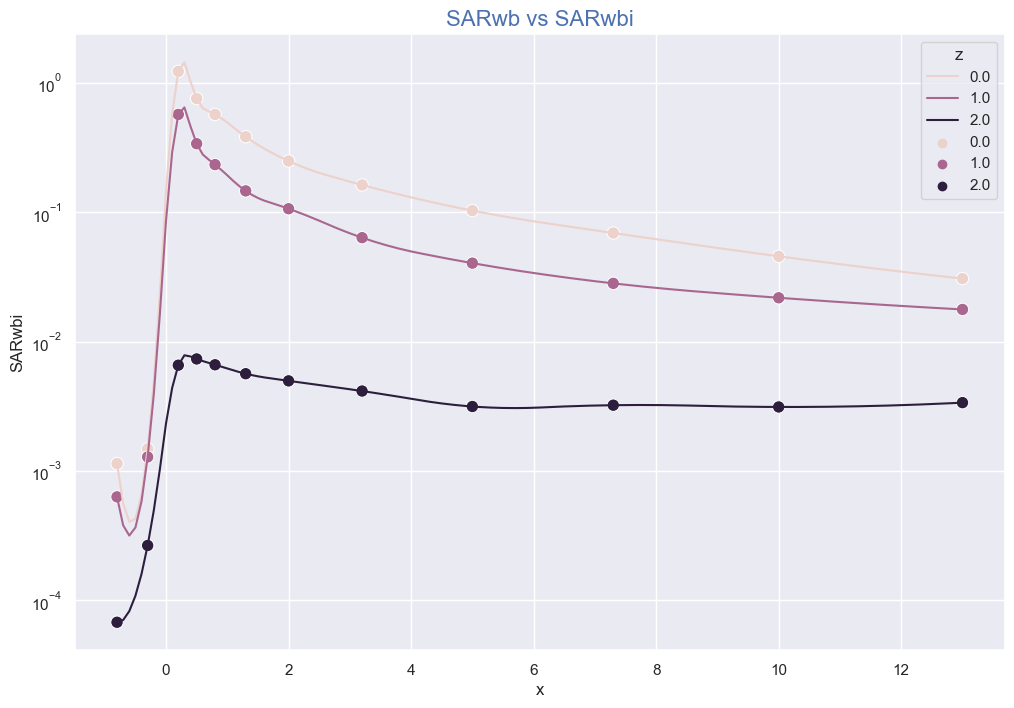

In [22]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(12, 8))
mask = (Sall.y == 0) & (Sall.z.isin([0,1,2]))
Sall[mask]
sn.lineplot(data=Sall[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=Sall[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_yscale('log')
ax.set_title('SARwb vs SARwbi', fontsize=16, color='b')
;

Danie's SAR points (`SARwb`) all lie on the lines for my log-linear interpolated data (`SARwbi`)

## Metadata for Sall dataframe 

In [23]:
# Create dict for S column name metadata
Snames = {'SE': 'S(E) levels',
          'SH': 'S(H) levels',
          'Smax': 'Smax levels',
          'SARps': 'peak spatial SAR',
          'SARwb': 'WBA SAR',
          'SARwbi': 'WBA SAR (interpolated)',
         }

## Save the S DataFrame as hdf5 store with metadata

In [24]:
# Set the file name of the hdf5 store
Sfile = datadir + f'{t.antenna_folder}.hdf5'

# Save the data into an hdf5 store (without x,y,z data)
Sdata = Sall.drop(columns=['x','y','z'])
h5store(Sfile, Sdata, **Snames)
print(f'S DataFrame saved to: {Sfile}')
print(f'{len(Sall) = }')

S DataFrame saved to: ../antennas/MBSpanel_2/data/MBSpanel_2.hdf5
len(Sall) = 1298751


## Scratch

In [2]:
from RFcalcUC_v9 import *
panelAntenna('darkblue')
mlab.show()

In [34]:
COLORS.keys()

dict_keys(['blue', 'darkblue', 'green', 'darkgreen', 'red', 'darkred', 'coral2', 'yellow', 'gold', 'black', 'orange', 'magenta', 'white', 'pink', 'brown', 'olive', 'lightgrey', 'darkgrey'])

In [32]:
Sall

x    y    z        SE        SH      Smax  SARwb  SARwbi
0        -1.0 -7.0 -3.0  0.007138  0.007219  0.007219    NaN     NaN
1        -1.0 -7.0 -2.9  0.007635  0.007725  0.007725    NaN     NaN
2        -1.0 -7.0 -2.8  0.007646  0.007729  0.007729    NaN     NaN
3        -1.0 -7.0 -2.7  0.007189  0.007244  0.007244    NaN     NaN
4        -1.0 -7.0 -2.6  0.006404  0.006415  0.006415    NaN     NaN
...       ...  ...  ...       ...       ...       ...    ...     ...
1298746  14.0  7.0  2.6  0.063321  0.062714  0.063321    NaN     NaN
1298747  14.0  7.0  2.7  0.054166  0.053716  0.054166    NaN     NaN
1298748  14.0  7.0  2.8  0.048698  0.048395  0.048698    NaN     NaN
1298749  14.0  7.0  2.9  0.045836  0.045667  0.045836    NaN     NaN
1298750  14.0  7.0  3.0  0.044632  0.044577  0.044632    NaN     NaN

[1298751 rows x 8 columns]